<a href="https://colab.research.google.com/github/sithin42/INT-PROSTATE-Contour-Stability/blob/main/1_ContourGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Part 1 - Contour Generator** 

This notebook was designed to visualize the impact of various augmentation scenarios on a sample data. It can be run locally on your computer or on google colab.

The sample data that we used in example was extracted from "QIN Prostate" dataset available as an open source at cancer imaging archive. This is a multiparametric MRI dataset and contains T2w, ADC and SUB sequences for two time points. 

More information can be found @ https://wiki.cancerimagingarchive.net/display/Public/QIN-PROSTATE-Repeatability

In this example we will only use the T2w sequences acquired at the first time point of two patients.

**Step 1:** Adjust the notebook for local and colab compatability

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

ROOT_PATH = "./"
#Loading the example data from github
if IN_COLAB:
  ROOT_PATH = "./INT-PROSTATE-Contour-Stability"
  !git clone https://github.com/sithin42/INT-PROSTATE-Contour-Stability.git
  import sys
  sys.path.append(ROOT_PATH)
  

**Step 2:** Install and import the packages

TorchIO and PyTorch (package name-torch) are two deep learning related packages used here.

TorchIO is a Python library for efficient loading, preprocessing, augmentation and patch-based sampling of medical images in deep learning. In this work we used this package for augmenting contours. 

More info can be found @ https://torchio.readthedocs.io/index.html

Pytorch is a deep learning framework. 

More info can be found @ https://pytorch.org/

In [ ]:
#Requirements 
!pip install torchio
!pip install SimpleITK
!pip install scikit-image
!pip install scipy
!pip install torch


In [ ]:
import torchio as tio
import torch
import os
import SimpleITK as sitk
from tqdm import tqdm
import numpy as np
from skimage import measure
import scipy
from utils import vol_dice_score

from ipywidgets import widgets, interact
import matplotlib.pyplot as plt

**Step 3:** Loading and visualizing the data

Here PID can either be set to "PCAMPMRI-00002" or "PCAMPMRI-00001". There are the two patients extracted from QIN prostate dataset. 

In the original form, the data was provided as a dicom series but for our convenience, we merged the slices to form a single 3D volume and was exported for convenient handling.

If you are running this notebook locally, you can find the data inside the "data" folder.

If you are running this notebook on Colab, you can find the data inside the following location: INT-PROSTATE-Contour-Stability/data. 

In [ ]:
PID = "PCAMPMRI-00002"#"PCAMPMRI-00001"

img_path = os.path.join(ROOT_PATH,"data",PID,"image.nii.gz")
mask_path = os.path.join(ROOT_PATH,"data",PID,"mask.nii.gz")


Quick load and visualization of data using TorchIO

In [ ]:
sub = tio.Subject(img=tio.ScalarImage(img_path),mask=tio.LabelMap(mask_path))
sub.plot()#Fast Visualization

The following visualization is a more traditional approach and allows more interactive inspection.

In [ ]:
#Interactive Visualization

sitk_img = sitk.ReadImage(img_path)
sitk_mask = sitk.ReadImage(mask_path)

img_arr = sitk.GetArrayFromImage(sitk_img)#Z,X,Y
mask_arr = sitk.GetArrayFromImage(sitk_mask)

spacing_W, spacing_H, _ = sitk_img.GetSpacing()

def visualize(i):
    
    plt.imshow(img_arr[i],cmap='gray')
    if mask_arr[i].sum()>0:
        plt.contour(mask_arr[i])
    plt.show()
    
interact(visualize, i=widgets.IntSlider(len(mask_arr)//2,0,len(mask_arr),1))

**Step 4:** Introduction to Contour Augmentations & Biases


---


**In Plane Augmentation:** Essentially simulates the variability in contouring within the axial plane (i.e, X, Y dimensions associated with a slice). The width, w, and height, h, associated with the contour drawn by the radiologist (left) in the axial plane are allowed to undergo random perturbation by a delta value - dw, dh ~ U ( -2.7mm, 2.7mm ). This results in a transformed contour (right) with width, w’ = w+dw, and height, h’ =h+dh. In addition to this, the contour is also allowed to randomly rotate in the z-axis at an angle, α ~ U(-5°,+5°). 

For in-plane augmentation, we considered two possible biases to model intra- and inter-observer variability in contouring: 

(a) Random bias, where the contour associated with each slice can undergo random transformations independently across the X and Y dimensions.

(b) Systematic bias mimics the behavior of radiologists in a  clinical scenario where some are systematically more “abundant” in their contouring while some others are more “restrictive”.

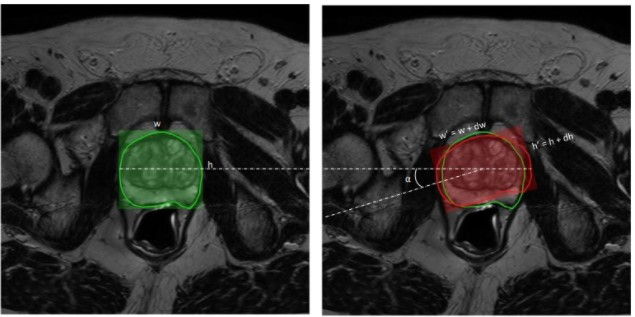

**Out Plane Augmentation:** Essentially represents a scenario where the differences in the segmented ROIs happens due to the difference in the choices of the first and/or last slice in the craniocaudal direction. In this case, we allowed a maximum shift of one slice on either side related to the choice of the prostate ROI boundary.

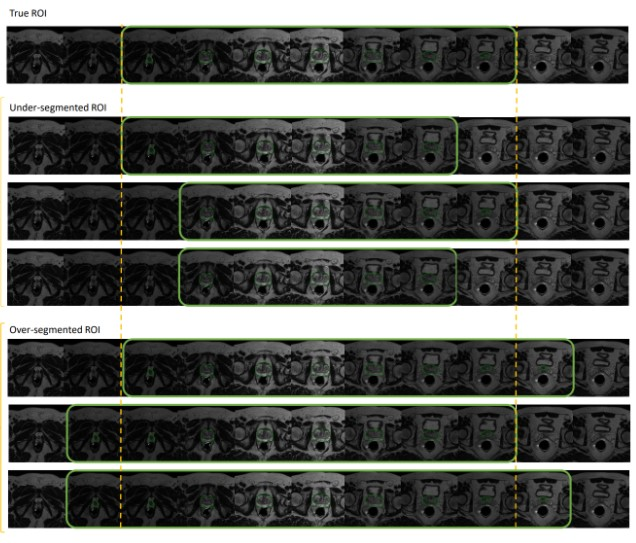



**In&Out Plane Augmentation:** Is a random combination of in & out plane augmentations. 



In [ ]:
class ContourInPlaneAug(object):
    
    def __init__(self, w_spacing, h_spacing, w_stdMM,h_stdMM, angle, ob_type="random"): 
        '''
        w_spacing, h_spacing represents the spacing of the input image
        
        w_aMM, w_bMM are the measurements in MM; acts as the bound for variability along the in-plane directions
        
        angle - rotate Z such that ~ U(-angle,angle)
        
        ob_type specifies the bias types; can be either 'random' or 'systematic'
        '''
        
        
        self.w_spacing = w_spacing
        self.h_spacing = h_spacing
        
        self.w_stdMM = w_stdMM
        self.h_stdMM = h_stdMM
        self.angle = angle
        
        self.ob_type = ob_type
    
    def __call__(self, mask):  
        
        sys_type = np.random.choice(["inc","dec"]) #will only be considered if the bias type is systematic; 

        out_mask = torch.zeros_like(mask)
        
        z_indeces = [i.item() for i in torch.where(mask)[1].unique()] #To identify the slices where the ROI is present
        
        for z in z_indeces:
            
            if self.ob_type=="random":
                w_stdVOX = np.ceil(np.random.uniform(-self.w_stdMM,self.w_stdMM)/self.w_spacing) #conversion to equivalent voxels
                h_stdVOX = np.ceil(np.random.uniform(-self.h_stdMM,self.h_stdMM)/self.h_spacing)
                
            elif self.ob_type=="systematic":
                
                if sys_type == "inc":
                    w_stdVOX = np.ceil(np.random.uniform(0,self.w_stdMM)/self.w_spacing)
                    h_stdVOX = np.ceil(np.random.uniform(0,self.h_stdMM)/self.h_spacing)
                else:
                    w_stdVOX = np.ceil(np.random.uniform(-self.w_stdMM,0)/self.w_spacing)
                    h_stdVOX = np.ceil(np.random.uniform(-self.h_stdMM,0)/self.h_spacing)
            
            props = measure.regionprops(mask[0,z].data.numpy())
            w_min,h_min,w_max,h_max = props[0].bbox

            dw = w_max - w_min
            dh = h_max - h_min

            aug_dw = dw + w_stdVOX 
            aug_dh = dh + h_stdVOX 

            factor_w  = np.round(aug_dw/dw,2)
            factor_h = np.round(aug_dh/dh,2)
            
            if factor_w<=0:
                continue;
            
            if factor_h<=0:
                continue;
            
            scales = (1,1,factor_w,factor_w,factor_h,factor_h)#Z,Z,X,X,Y,Y
        
            degrees = (-self.angle, self.angle, 0, 0, 0, 0)#Z,X,X,Y,Y

            transform = tio.RandomAffine(scales=scales,degrees=degrees,p=1)

            out_mask[0,z] = transform(mask[0,z].unsqueeze(0).unsqueeze(0))[0,0]
            
           
        
        out_mask[out_mask>0.5] = 1
        out_mask[out_mask<=0.5] = 0
        
        
        return out_mask
        
        

In [ ]:
class ContourOutPlaneAug(object):
    
    def __init__(self, scale_a, scale_b,angle, delta_z):
        
        '''
        scale_a, scale_b and angle are transformation params and is only used when we synthesize masks beyond the GT boundaries
        
        delta_z is the maximum shift or out-plane augmentation allowed
        '''
        
        self.scale_a = scale_a
        self.scale_b = scale_b
        self.angle = angle
        
        self.delta_z = delta_z
        
    def __call__(self, mask):
        
        mask = mask.clone()
    
        aug_num_slices = np.random.randint(0, self.delta_z+1) #low, high (excluded high)
        
        z_indeces = [i.item() for i in torch.where(mask)[1].unique()]
        
        z_min, z_max = min(z_indeces), max(z_indeces)
        
        for i in range(aug_num_slices):
        
            dz = z_max-z_min

            if dz>0: 

                ref_z = np.random.choice([z_min,z_max])
                
                flag = -1 if ref_z==z_min else 1

                aug_type = "del" if np.random.uniform()>0.5 else "add"
            
                if mask[0,ref_z].sum()>0: #which means contour exists in that place, possible that it got deleted during iteration
                
                    if aug_type=="del":
                        if ref_z+flag in range(mask.shape[1]):
                            if mask[0,ref_z+flag].sum()==0:#to check if new contours were inserted up or down
                                mask[0,ref_z] = torch.zeros(*mask[0,ref_z].shape)
                                
                        else:#if ref_z+flag is outside the boundary
                            mask[0, ref_z] = torch.zeros(*mask[0,ref_z].shape)

                    elif aug_type=="add":

                        if ref_z+flag in range(mask.shape[1]):
                            
                            if mask[0,ref_z+flag].sum()==0:

                                scales =(1,1,self.scale_a,self.scale_b,self.scale_a,self.scale_b)
                                degrees = (-self.angle, self.angle,0,0,0,0)

                                transform = tio.RandomAffine(scales=scales,degrees=degrees,p=1)

                                mask[0,ref_z+flag] = transform(mask[0,ref_z].unsqueeze(0).unsqueeze(0))[0,0]

        mask[mask>0.5] = 1
        mask[mask<=0.5] = 0
        
        return mask
   


**Step 5:** Parameter associated with the in-silico contour generation. 




In [ ]:
'''
IN_AUG_PARAMS: 
w_spacing and h_spacing - are spacing variables and will be computed dynamically; 
w_stdMM and h_stdMM - indicates the standard deviation associated with the variability of contour allowed in X and Y axis in mm
angle - specifies the bound of contour rotation allowed
ob_type - essentially is the bias type

OUT_AUG_PARAMS:
scale_a and scale_b - specifies how the shifted boundary contour needs to be scaled with respect to the closest ROI
delta_z - essentially specifies the maximum number of times the random shift can be performed on either sides. Higher number increases the likelyhood of shift operation.

AUGMENT_COUNT - specifies the number of synthetic contours that needs to be generated for a single input GT mask

AUG_TYPE - specifies the augmentation types. Can take values in_plane, out_plane, or inout_plane

BIAS TYPE - specifies the bias type. Can take values "random" or "systematic" for in or inout_plane augmentations, for out_plane augmentation the bias should be an empty string

'''


IN_AUG_PARAMS = {'w_spacing':None,"h_spacing":None,'w_stdMM':2.7,'h_stdMM':2.7, 'angle':5,'ob_type':None}
OUT_AUG_PARAMS = {'scale_a':0.6,'scale_b':0.8,'angle':5,'delta_z':2}
AUGMENT_COUNT = 5

AUG_TYPE = "inout_plane"#or "in_plane" or "out_plane"
BIAS_TYPE = "random"#or "systematic"

**Step 6:** Main routine to synthesize contours. 

You can update the parameters above and re-run this step to test various augmentation scenarios

1.   in_plane augmentation with random bias
2.   in_plane augmentation with systematic bias
3.   out_plane augmentation
4.   inout_plane augmentation with random bias
5.   inout_plane augmentation with systematic bias





In [ ]:
aug_mask_arr_list = []

def main():
  assert AUG_TYPE in ["in_plane","out_plane","inout_plane"], "Invalid aug_type!"

  if AUG_TYPE!="out_plane":
    assert BIAS_TYPE in ["random","systematic"], "Invalid bias_type!"
  else:
    assert BIAS_TYPE=="", "For out_plane augmentation bias_type should be an empty string"
  
  if AUG_TYPE=="in_plane":
                      
          IN_AUG_PARAMS["w_spacing"] = spacing_W
          IN_AUG_PARAMS["h_spacing"] = spacing_H
          IN_AUG_PARAMS["ob_type"] = BIAS_TYPE

          ContourAug = tio.Lambda(ContourInPlaneAug(**IN_AUG_PARAMS),types_to_apply=[tio.LABEL])

  elif AUG_TYPE=="out_plane":

      ContourAug = tio.Lambda(ContourOutPlaneAug(**OUT_AUG_PARAMS), types_to_apply=[tio.LABEL])

  elif AUG_TYPE=="inout_plane":

      IN_AUG_PARAMS["w_spacing"] = spacing_W
      IN_AUG_PARAMS["h_spacing"] = spacing_H
      IN_AUG_PARAMS["ob_type"] = BIAS_TYPE

      ContourAug = tio.Compose([
          tio.Lambda(ContourInPlaneAug(**IN_AUG_PARAMS),types_to_apply=[tio.LABEL]),
          tio.Lambda(ContourOutPlaneAug(**OUT_AUG_PARAMS), types_to_apply=[tio.LABEL])
      ])


  pbar = tqdm(range(AUGMENT_COUNT),desc=f"Generating {AUG_TYPE} augmentation with {BIAS_TYPE} bias", position=0)
  sub = tio.Subject(mask=tio.LabelMap(tensor=mask_arr[np.newaxis,...]))

  for i in range(AUGMENT_COUNT):
      
      aug_sub = ContourAug(sub)
      aug_mask_arr = aug_sub["mask"]["data"][0].numpy()
      aug_mask_arr_list.append(aug_mask_arr)
      
      indeces = np.unique(np.argwhere(mask_arr)[:,0])

      k = indeces[np.random.randint(len(indeces))]
      dice = vol_dice_score(aug_mask_arr[k], mask_arr[k])
      
      plt.imshow(img_arr[k],cmap='gray')
      plt.contour(aug_mask_arr[k], colors='red')#Synthetic ROI
      plt.contour(mask_arr[k], colors='green')#GT ROI
      plt.title(f"Contour #{i+1} (DI:{dice:0.2f})")
      plt.show()
      pbar.update()
      
#     #To export the augmented mask
#     aug_sitk_mask = sitk.GetImageFromArray(aug_mask_arr)
#     aug_sitk_mask.SetOrigin(sitk_img.GetOrigin())
#     aug_sitk_mask.SetSpacing(sitk_img.GetSpacing())
#     sitk.WriteImage(aug_sitk_mask,"./aug_sitk_mask.nii.gz")
      

main()


**Step 7:** Interactive visualization of a synthetic ROI generated

In [ ]:
aug_mask_arr = aug_mask_arr_list[np.random.randint(0,len(aug_mask_arr_list))]

def visualize(i):
    
    plt.imshow(img_arr[i],cmap='gray')
    if mask_arr[i].sum()>0:
        plt.contour(mask_arr[i],colors='green')
    if aug_mask_arr[i].sum()>0:
        plt.contour(aug_mask_arr[i],colors='red')#aug_mask_arr will be the last generated mask
    
    plt.title(f"Slice:{i}, DI:{vol_dice_score(aug_mask_arr[i],mask_arr[i]):0.2f}")
    plt.show()
    
interact(visualize, i=widgets.IntSlider(len(mask_arr)//2,0,len(mask_arr),1))